참고 노트북
- [링크](https://www.kaggle.com/code/mursideyarkin/mobile-games-ab-testing-with-cookie-cats/notebook)

이 노트북에서 배울 수 있는 것
- AB test

평균차이 비교 (proportion z-test) vs boostrapping

와 AB test에 대한 감이 아예 없네

분석 배경
- cookie-cats라는 게임에서 gate를 어디에 세울지 정하려고
- gate는 시간을 기다리거나 or 유료 결제

In [1]:
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Download latest version
path = kagglehub.dataset_download("mursideyarkin/mobile-games-ab-testing-cookie-cats")

In [2]:
import pandas as pd
import os

df = pd.read_csv(os.path.join(path, "cookie_cats.csv"))

In [3]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [4]:
n_user = df["userid"].nunique()
print(n_user)
print(df.shape[0] == n_user)

90189
True


In [5]:
df.groupby("version")[["userid"]].nunique()

# -> A/B 테스트하기 전 비슷한 숫자가 존재하는지 확인!

,userid
version,
gate_30,44700
gate_40,45489


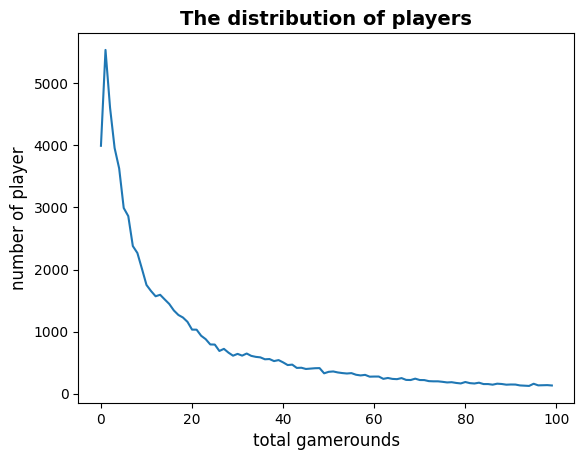

In [6]:
import matplotlib.pyplot as plt
# The distribution of game rounds

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby("sum_gamerounds")["userid"].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot()
plt.title("The distribution of players", fontweight="bold", size=14)
plt.xlabel("total gamerounds", size=12)
plt.ylabel("number of player", size=12)
plt.show()

In [8]:
num_zero_gamerounds = (df["sum_gamerounds"] == 0).sum()
print(num_zero_gamerounds)
print(num_zero_gamerounds / len(df))

# -> 설치해놓고 안한사람도 이정도나 존재하는구나
# 많은거야, 적은거야?

3994
0.0442847797403231


In [10]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


In [11]:
# Calculating 1-day and 7-days retention for each A/B group
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


sum_gamerounds가 30 or 40보다 적으면 의미없는거 아닌가?

In [50]:
print(df['retention_1'].value_counts(normalize=True))
print(df['retention_7'].value_counts(normalize=True))

retention_1
False    0.55479
True     0.44521
Name: proportion, dtype: float64
retention_7
False    0.813935
True     0.186065
Name: proportion, dtype: float64


In [51]:
# version으로 그룹 묶어서 retention_1과 retention_7의 차이 비교
print(df.groupby('version')[['retention_1', 'retention_7']].mean())

         retention_1  retention_7
version                          
gate_30     0.448188     0.190201
gate_40     0.442283     0.182000


gate_30 > gate_40 ??

In [52]:
df[df['userid']==488]

,userid,version,sum_gamerounds,retention_1,retention_7
4,488,gate_40,179,True,True


## A/B Testing: Bootstrapping

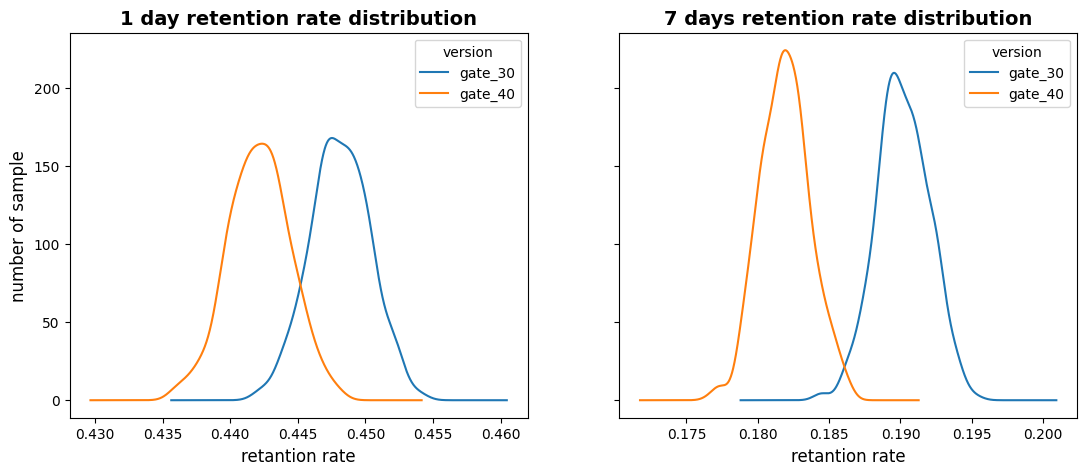

In [ ]:
# 각 A/B 그룹에 대해 부트스트랩 평균값을 저장할 리스트 생성
boot_1d = []
boot_7d = []
for i in range(500):  # 500번 반복하여 부트스트랩 샘플 추출
    # 부트스트랩 샘플을 뽑아서 version별 1일 리텐션 평균 계산
    # frac=1은 데이터셋 전체를 표본으로 추출한다는 의미입니다.
    # 즉, frac=1이면 데이터의 100%를 복원추출하여 부트스트랩 샘플을 만듭니다.
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    # 부트스트랩 샘플을 뽑아서 version별 7일 리텐션 평균 계산
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# 리스트를 데이터프레임으로 변환
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# 부트스트랩 분포의 커널 밀도 추정 그래프 그리기
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)  # 리텐션 비율 (x축)
ax1.set_ylabel("number of sample",size=12)  # 샘플 개수 (y축)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)  # 1일 리텐션

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)  # 리텐션 비율 (x축)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)  # 7일 리텐션
plt.show()

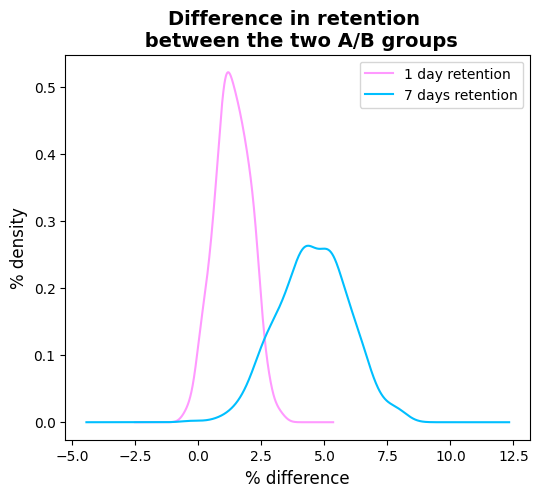

In [13]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

In [14]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Calculating the probability that 7-days retention is greater when the gate is at level 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")

The probability that 1-day retention is greater when the gate is at level 30: 98.0%       
The probability that 7-days retention is greater when the gate is at level 30: 99.8% 


# T-test

In [39]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# df: Cookie Cats dataset
# version: "gate_30" / "gate_40"
# retention_1, retention_7: 0/1 binary

A = df[df['version'] == 'gate_30']
B = df[df['version'] == 'gate_40']

In [41]:
# successes = retention=1 count
count = np.array([
    A['retention_1'].sum(),
    B['retention_1'].sum()
])

# observations = total size
nobs = np.array([
    A.shape[0],
    B.shape[0]
])

# two-sided
z_stat_1, p_val_1_z = proportions_ztest(count, nobs, alternative='two-sided')
print("\n1-day Retention Z-test (two-sided)")
print("z-stat:", z_stat_1)
print("p-value:", p_val_1_z)

# larger (Ha: gate_30 > gate_40)
z_stat_1_larger, p_val_1_larger = proportions_ztest(count, nobs, alternative='larger')
print("\n1-day Retention Z-test (larger; gate_30 > gate_40)")
print("z-stat:", z_stat_1_larger)
print("p-value:", p_val_1_larger)

# smaller (Ha: gate_30 < gate_40)
z_stat_1_smaller, p_val_1_smaller = proportions_ztest(count, nobs, alternative='smaller')
print("\n1-day Retention Z-test (smaller; gate_30 < gate_40)")
print("z-stat:", z_stat_1_smaller)
print("p-value:", p_val_1_smaller)


1-day Retention Z-test (two-sided)
z-stat: 1.7840862247974725
p-value: 0.07440965529691913

1-day Retention Z-test (larger; gate_30 > gate_40)
z-stat: 1.7840862247974725
p-value: 0.03720482764845957

1-day Retention Z-test (smaller; gate_30 < gate_40)
z-stat: 1.7840862247974725
p-value: 0.9627951723515404


아래 Kaggle Notebook(“Mobile Games AB Testing with Cookie Cats”)의 전체 분석 흐름을 기준으로, **전문적인 A/B 테스트 관점에서 명확한 한계점**들을 정리해줄게.
게임 업계·데이터 사이언스 실무 기준으로 보는 “이 분석이 갖는 구조적, 통계적, 데이터적 한계점”이다.

---

# 1. 원본 데이터가 아니라 “요약된 집계 데이터(aggregated data)”다

Notebook에 쓰인 CSV는 실제 로그(raw event log)가 아니라 이미 집계된 형태이다.

### 포함된 정보:

* retention_1 (0/1)
* retention_7 (0/1)
* sum_gamerounds (첫 7일 총 라운드)
* version (A/B)

### 미포함된 정보:

* 실제 플레이 타임스탬프
* conversion funnel
* 결제 여부
* 국가/디바이스/OS 등 사용자 속성
* 유입 채널 정보

**한계:**
누락된 속성들로 인해 **Confounder를 통제할 수 없다.**
예: 국가별 retention 차이가 클 경우, 그룹 내 국가 구성비가 다르면 잘못된 결론 가능.

---

# 2. A/B 그룹이 정말 “랜덤 배정”인지 검증하지 않음

Notebook에서는 다음 sanity check만 했다:

```
각 A/B 그룹의 유저 수가 비슷한가?
```

하지만 실무 A/B 테스트에서 체크해야 할 추가 필요 요소:

* 국가 구성비 차이
* 신규/기존 유저 비율 차이
* 디바이스/OS 비율 차이
* 유입 날짜 편향
* 프로모션/이벤트 중복 영향
* 실험 웨이브(rollout) 타이밍 문제

**한계:**
표본 수가 비슷한 것만으로 random assignment가 보장되는 것은 아니다.

---

# 3. 단일 지표(retention)만 보고 결론을 냄

Notebook 결론:

> “7-day retention이 유의하게 낮으므로 gate40은 배포하면 안 된다.”

하지만 실제 게임 지표는 다음이 함께 중요:

* LTV (Life Time Value)
* 구매 conversion
* 첫 일주일 결제 수익
* DAU 변화
* FUNNEL depth progression
* early churn 감소 여부
* high-value user 행동 변화

**한계:**
Retention만으로는 실제 비즈니스 임팩트를 판단할 수 없음.
Retention이 조금 감소해도 결제가 늘면 오히려 수익이 증가할 수 있다.

---

# 4. 부트스트랩 방식 자체의 한계

Notebook에서는 부트스트랩을 사용하지만, 다음과 같은 기술적 한계 존재:

### (1) 데이터가 i.i.d.라고 가정

게임 유저 행동에는 종종 dependency가 있다:

* 친구 초대
* 소셜 길드
* 이벤트 타임 기반 참여 변동
  이런 구조에서는 부트스트랩이 과도한 확신을 줄 수 있다.

### (2) heavy-tailed metric 처리 못함

LTV/결제액 등은 강한 long-tail → 부트스트랩만으로는 불안정.

### (3) 편향된 표본을 그대로 복제

실험 기간 동안 user cohort가 특이하면
부트스트랩도 그대로 반영 → 미래 예측 부정확.

---

# 5. 샘플링 기간 및 시장 외부 요인 통제 안됨

Retention은 특정 날짜·특정 주차의 외부 요인에 민감하다:

* 업데이트 영향
* 게임 내 이벤트/보상 정책
* 마케팅 burst
* 특정 국가 공휴일/주말 효과
* 버그 영향

Notebook에서는 이러한 것을 고려하지 않았다.

**한계:**
“단일 주차의 실험 결과가 장기적으로도 동일할 것이다”라는 가정이 매우 약하다.

---

# 6. 실제 실험 구조를 검증하지 않음 (A/A 테스트 미비)

실험에서 필수적인 A/A test 확인이 없다.

* A 그룹을 두 개로 나누어 retention 분포를 비교
* 실험 시스템 자체가 noise-free인지 확인

Notebook은 이를 생략했다.

---

# 7. 1-day와 7-day retention을 독립 지표로 다룸

Retention_1과 retention_7은 통계적으로 강하게 상관돼 있음.

### 예:

Day1에서 남은 유저만 day7 데이터에 등장.
즉 retention_7은 retention_1의 조건부 지표다.

하지만 Notebook은 이를 독립 지표처럼 다룬다.

**한계:**
동일한 유저 집단 흐름을 구조적으로 분석하지 못함.

---

# 8. 사용자 이질성(Heterogeneity)을 고려하지 않음

모든 유저를 동일한 집단으로 간주하지만 실제로는:

* 코어 유저 vs 캐주얼 유저
* 신규 vs 기존
* 국가 차이
* 디바이스 성능
* 레벨 달성 속도 차이
* 과금자 vs 비과금자

그룹별로 실험 효과가 다르게 나타날 수 있다.
이를 segmentation했다고 가정하지 않는다.

---

# 9. Gate 이동이 retention에 영향을 주는 “원인”을 분석하지 않음

Notebook은 오직 “효과의 방향”만 본다.

실무에서는 다음이 중요하다:

* gate 변경이 어떤 매커니즘으로 churn 증가를 유발했나?
* 낮은 retention의 root cause는?
* 특정 레벨 난이도 급상승 때문인가?
* 보상 구조 변화인가?

Notebook 분석은 purely statistical, zero causal analysis.

---

# 10. 시계열적 실험 효과(time-based effect) 미분석

Retention 실험은 실험 날짜에 따라 다르게 나타날 수 있다.

예:

* 실험 초기에는 curiosity effect
* 후반에는 fatigue effect
  Notebook은 이 부분을 전혀 다루지 않는다.

---

# 11. power analysis/샘플 사이즈 설계 없음

실험 시작 전에 결정해야 할 것:

* 필요한 샘플 수
* detectable effect size
* minimum effect of interest

Notebook에서는 뒤늦게 데이터 보고 결론만 내림.

---

# 최종 요약: Kaggle Notebook의 핵심 한계(실무 기준)

1. **요약 데이터만 사용 → confounder 통제 불가**
2. **랜덤 배정 검증 부족 → 그룹 구성비 왜곡 가능**
3. **Retention만 보고 결정 → 수익/LTV 고려 없음**
4. **부트스트랩 방식의 i.i.d. 가정 및 편향 전파 문제**
5. **A/A 테스트, 실험 파이프라인 검증 미흡**
6. **사용자 세그먼트별 이질성 무시**
7. **실험 메커니즘 분석 없음 (원인 파악 안됨)**
8. **시계열적 요인 고려 없음**
9. **power / 샘플사이즈 분석 없음**

즉, Notebook은 **교육용으로는 훌륭하지만, 실무 A/B 테스트 의사결정에는 매우 불충분**한 수준이다.

---

원하면 이어서:

* 이 분석을 “실무 수준”으로 업그레이드하는 방법
* Cookie Cats 데이터를 이용해 Bayesian A/B 테스트 수행하는 코드
* retention 외 KPI 포함한 다변량 A/B 테스트 설계 방법

까지 만들어줄게.